# LightForm Ti forming simulation study

This notebook contains the analysis routines for the forming simulation study archived at: 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.1423300.svg)](https://doi.org/10.5281/zenodo.1423300)

In [1]:
# we first import some useful modules
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.optimize import curve_fit
import re as re
import matplotlib as matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

# Data  Importing Functions


In [41]:
def get_stress_strain(data):
    '''
    This function loads the dilatometer data and 
    extracts only the data relevant to the test, stripping 
    away the heating and the data after unloading.
    '''
    points=data[:,0]
    force=data[:,4]
    strain=data[:,5]
    TrueStress=data[:,6]
    TrueStrain=data[:,7]
    deltaL=data[:,3]
    return TrueStress,TrueStrain

def get_temp_time(data):
    '''
    This function loads the dilatometer data and 
    extracts only the time and temperature data 
    relevant to the test, stripping away the 
    heating and the data after unloading.
    '''
    strain=data[:,7]
    temp=data[:,2]
    return temp,strain


def clean_data(file_list):
    '''
    This function takes a file list and loads the clean data into a dictionary, indexed by filename.
    '''
    tests={}
    for file in file_list:
        if file not in exceptions:
            f=open(file,'r',encoding='latin-1')
            data=np.loadtxt(f, skiprows=3)   
            s,e=get_stress_strain(data)
            tests[str(file)]=(s,e)
    return tests

def clean_data_temp(file_list):
    '''
    This function takes a file list and loads the clean data into a dictionary, indexed by filename.
    '''
    tests={}
    for file in file_list:
        if file not in exceptions:
            f=open(file,'r',encoding='latin-1')
            data=np.loadtxt(f, skiprows=3)   
            temp,time=get_temp_time(data)
            tests[str(file)]=(temp,time)
    return tests

def get_test_params_salim(filename):
    matches=re.search('(\d\d\d)_\w+_\w+_(\w+)_(\d+)_([-+\d\.]+)_(\w+)_(\d+)__(\d)\.asc',filename)
    test=matches[1]
    alloy=matches[2]
    temp=matches[3]
    strain_rate=str(float(matches[4]))
    cooling=matches[5]
    profile=matches[6]
    attempt=matches[7]
    return test,temp,strain_rate,attempt

exceptions=['060_Compression_Salim_Ti64_700_-2.0_001__1.asc']

## Functions for data analysis

In [42]:
def fit_test(filename,plotting=False):
    data=tests[filename]
    s=data[0]
    e=data[1]
    e_strain=e[np.where(e <0.02)]
    e_stress=s[np.where(e <0.02)]
    e_strain=e_strain[np.where(e_stress>10.0)]
    e_stress=e_stress[np.where(e_stress>10.0)]
    proof_vals=proof_stress(e,s,e_strain,e_stress,plotting=plotting)
    if plotting == True:
        for proof,values in proof_vals.items():
            plt.plot(values[0],values[1],'ro',ms=12.0,alpha=0.8)
    return proof_vals

def elastic(strain,E,c):
    return strain*E+c

def proof_stress(strain,stress,elasticStrain,stressElastic, plotting = False):
    proof_vals=dict()
    fit,var=curve_fit(elastic,elasticStrain,stressElastic) 
    strain_fit=np.linspace(0,elasticStrain[-1]*2)
    stress_fit=elastic(strain_fit,fit[0],fit[1])
    for proof in [0.002,0.005,0.5]:
        proof_strain=strain_fit+proof
        stress_range = stress[np.where(strain<proof_strain[-1])]
        strain_range = strain[np.where(strain<proof_strain[-1])]
        strain_diff_list=[]
        for (stress_val,strain_val) in zip(stress_range,strain_range):
            strain_guess=np.interp(stress_val,stress_fit,proof_strain)
            strain_diff=strain_guess-strain_val
            strain_diff_list.append(np.abs(strain_diff))
        stress_intercept=stress_range[np.where(strain_diff_list==np.min(strain_diff_list))]
        strain_intercept=strain_range[np.where(strain_diff_list==np.min(strain_diff_list))]
        proof_vals[str(proof)]=[strain_intercept,stress_intercept]
    if plotting == True:
        plt.figure()
        plt.plot(strain,stress,'o',alpha=0.5)
        plt.plot(strain_fit,stress_fit,'r')
        plt.plot(strain_fit+0.002,stress_fit,'g') #add 0.2% or 0.002 for 0.2% proof stress
        plt.plot(strain_fit+0.005,stress_fit,'y') #add 0.5% or 0.005 for 0.5% proof stress
        plt
        plt.legend(('Stress-Strain','Elastic','0.2% proof','0.5% proof'),loc=0)
        plt.xlabel('Strain')
        plt.ylabel('Stress /MPa')
        plt.xlim([0,0.7])  
        plt.ylim(ymin=0)
    return proof_vals

## Functions  for plotting stress strain data

In [43]:
def plot_all_stress_strain(tests):
    
    # create lists of unique temperatures and strain rates
    temp_list=[]
    strain_rate_list=[]
    for key in tests.keys():
        test,temp,strain_rate,attempt=get_test_params_salim(str(key))
        temp_list.append(temp)
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    temps= list(np.unique(temp_list))
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))

    # create dictionaries for plot positions and plotting colours
    plt_temps={}
    plt_strain_rates={}
    plt_pos=[(0),(1),(2)]
    for temp, pos in zip(temps, plt_pos):
        plt_temps[temp]=pos
    plt_colors = ['C0','C1','C2']
    for strain_rate,color in zip(strain_rates,plt_colors):
        plt_strain_rates[str(strain_rate)]=color

    # set up subplots and plot data 
    f,ax=plt.subplots(1,3,sharex='all',sharey='all',figsize=(15,5))
    for filename,data in tests.items():
        test,temp,strain_rate,attempt=get_test_params_salim(filename)
        pos=plt_temps[temp]
        col=plt_strain_rates[str(float(strain_rate))]
        ax[pos].plot(data[1],data[0],color=col)

    strain_rates[-1]=0
    
    # add legend with matching colours    
    ax[2].legend(strain_rates, title= 'log(strain rate ($s^{-1}$))',loc='center left', bbox_to_anchor=(1, 0.5))
    leg = ax[2].get_legend()
    for l,color in zip(leg.legendHandles,plt_colors):
        l.set_color(color)
    #add title and axis labels
    ax[0].set_ylabel('Stress (MPa)')
    ax[1].set_xlabel('True strain')
    for temp,pos in plt_temps.items():
        ax[pos].set_title('$'+str(temp)+'^\circ\mathrm{C}$')

def plot_all_proof(tests,proof_vals):
    
    # create lists of unique temperatures and strain rates
    temp_list=[]
    strain_rate_list=[]
    for key in tests.keys():
        test,temp,strain_rate,attempt=get_test_params_salim(str(key))
        temp_list.append(temp)
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    temps= list(np.unique(temp_list))
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))

    # create dictionaries for plot positions and plotting colours
    plt_temps={}
    plt_strain_rates={}
    plt_pos=[(0),(1),(2)]
    for temp, pos in zip(temps, plt_pos):
        plt_temps[temp]=pos
    plt_colors = ['C0','C1','C2']
    for strain_rate,color in zip(strain_rates,plt_colors):
        plt_strain_rates[str(strain_rate)]=color

    # set up subplots and plot data 
    f,ax=plt.subplots(1,3,sharex='all',sharey='all',figsize=(15,5))
    for filename,data in tests.items():
        test,temp,strain_rate,attempt=get_test_params_salim(filename)
        pos=plt_temps[temp]
        col=plt_strain_rates[str(float(strain_rate))]
        ax[pos].plot(data[1],data[0],color=col)
        
    for filename, proof_stresses in proof_vals.items():
        test,temp,strain_rate,attempt=get_test_params_salim(filename)
        pos=plt_temps[temp]
        col=plt_strain_rates[str(float(strain_rate))]
        proof_stress=proof_stresses['0.5'][0]
        proof_strain=proof_stresses['0.5'][1]
        ax[pos].plot(proof_stress,proof_strain,'ro',ms=10.0,alpha=0.5)      
    
    #ugly Salim fix
    
    strain_rates[-1]=0

    # add legend with matching colours    
    ax[2].legend(strain_rates, title= 'log(strain rate ($s^{-1}$))',loc='center left', bbox_to_anchor=(1, 0.5))
    leg = ax[2].get_legend()
    for l,color in zip(leg.legendHandles,plt_colors):
        l.set_color(color)
    #add title and axis labels
    ax[0].set_ylabel('Stress (MPa)')
    ax[1].set_xlabel('True strain')
    for temp,pos in plt_temps.items():
        ax[pos].set_title('$'+str(temp)+'^\circ\mathrm{C}$')
        
def get_proof_stress(proof_vals,proof_val='0.5'):

    strain_rate_list=[]
    for key in proof_vals.keys():
        test,temp,strain_rate,attempt=get_test_params_salim(str(key))
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))
    
    strain_rate_dict={}
    
    for strain_rate in strain_rates:
        strain_rate_dict[str(strain_rate)]=[[],[]]
    
    for filename, proof_stresses in proof_vals.items():
        test,temp,strain_rate,attempt=get_test_params_salim(filename)
        strain_rate=str(float(strain_rate))
        proof_stress=np.mean(np.array(proof_stresses[proof_val][1]))
        
        temperature=float(temp)
        strain_rate_dict[strain_rate][0].append(temp)
        strain_rate_dict[strain_rate][1].append(proof_stress)
    return strain_rate_dict;

def plot_proof_temp(fit_vals,p_vals=0.002):
    temperature=[]
    stress=[]
    strain_rates=['-2.0', '-1.0','0']
    strain_rate_dict=get_proof_stress(fit_vals, proof_val=str(p_vals))
    for strain_rate, data in sorted(strain_rate_dict.items()):
        plt.plot(data[0],np.array(data[1]),'o')
    plt.xlabel ('Temp')
    plt.legend(strain_rates,title= 'log(strain rate ($s^{-1}$))')
    plt.ylabel('Stress (MPa)');
    
def plot_all_temp_time(tests):
    
    # create lists of unique temperatures and strain rates
    temp_list=[]
    strain_rate_list=[]
    for key in tests.keys():
        test,temp,strain_rate,attempt=get_test_params_salim(str(key))
        temp_list.append(temp)
        strain_rate=str(float(strain_rate))
        strain_rate_list.append(strain_rate)
    temps= list(np.unique(temp_list))
    strain_rates=list(np.sort(np.unique(strain_rate_list).astype('float')))

    # create dictionaries for plot positions and plotting colours
    plt_temps={}
    plt_strain_rates={}
    plt_pos=[(0),(1),(2)]
    for temp, pos in zip(temps, plt_pos):
        plt_temps[temp]=pos
    plt_colors = ['C0','C1','C2']
    for strain_rate,color in zip(strain_rates,plt_colors):
        plt_strain_rates[str(strain_rate)]=color

    # set up subplots and plot data 
    f,ax=plt.subplots(1,3,sharex='all',sharey='all',figsize=(15,5))
    for filename,data in tests.items():
        test,temp,strain_rate,attempt=get_test_params_salim(filename)
        pos=plt_temps[temp]
        col=plt_strain_rates[str(float(strain_rate))]
        ax[pos].plot(data[1],data[0],color=col)

    strain_rates[-1]=0
    
    # add legend with matching colours    
    ax[2].legend(strain_rates, title= 'log(strain rate ($s^{-1}$))',loc='center left', bbox_to_anchor=(1, 0.5))
    leg = ax[2].get_legend()
    for l,color in zip(leg.legendHandles,plt_colors):
        l.set_color(color)
    #add title and axis labels
    ax[0].set_ylabel(r'Temperature ($^\circ\mathrm{C}$)')
    ax[1].set_xlabel('True strain')
    for temp,pos in plt_temps.items():
        ax[pos].set_title('$'+str(temp)+'^\circ\mathrm{C}$')

# Plotting and visualizing

Needs to be run when data is first unzipped.

In [44]:
cd './Ti64/Deformation/'

[Errno 2] No such file or directory: './Ti64/Deformation/'
/home/joao/Dropbox (Research Group)/Working Dropbox/LightForm Ti data/Ti64/Deformation


In [45]:
#create data structures and fit data
exceptions=['060_Compression_Salim_Ti64_700_-2.0_001__1.asc']
filenames = sorted(glob('*.asc'))
tests=clean_data(filenames)
temps=clean_data_temp(filenames)
proof_vals={}
for file in filenames:
    if file not in exceptions:
        vals=fit_test(file)
        proof_vals[file]=vals

## Plot stress strain curves

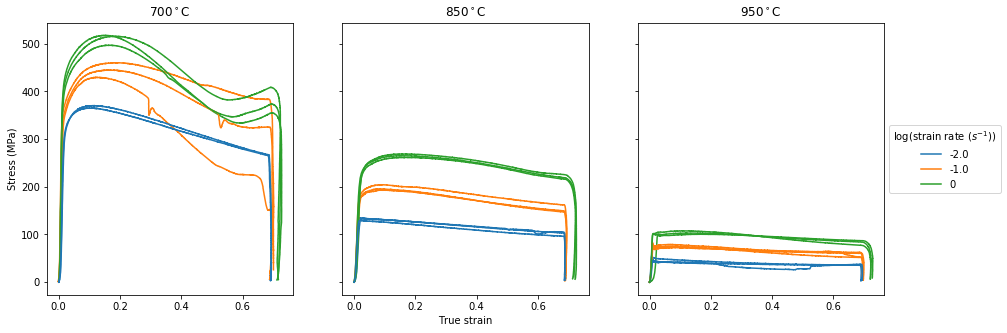

In [46]:
plot_all_stress_strain(tests)

## Plot stress strain data and proof values

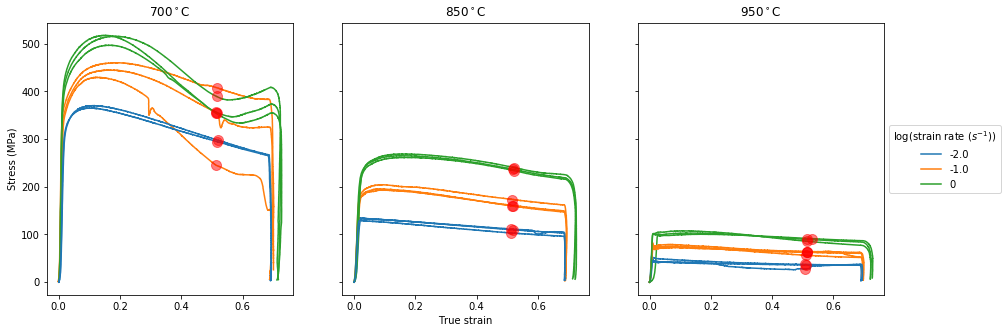

In [47]:
plot_all_proof(tests,proof_vals)

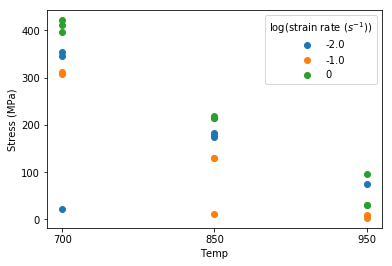

In [48]:
plot_proof_temp(proof_vals)

Plotting proof stresses at 0.002 strain:

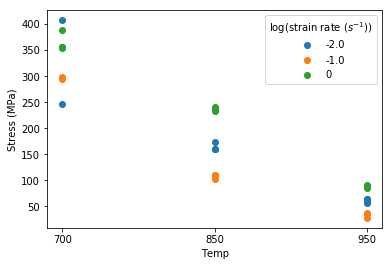

In [49]:
plot_proof_temp(proof_vals, p_vals=0.5)

## Testing soundness by plotting temperature

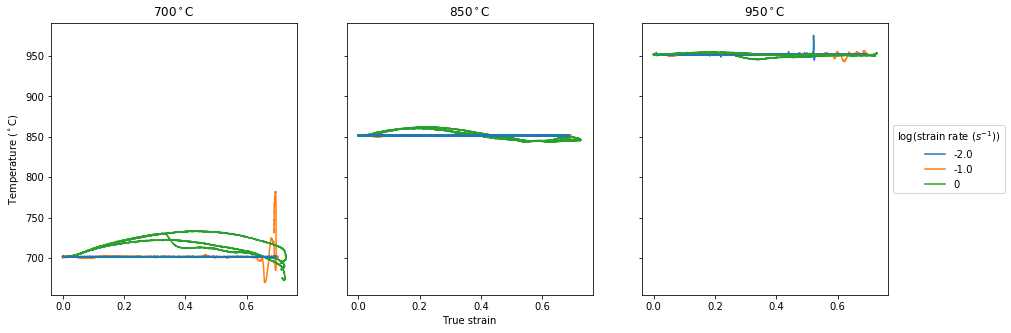

In [52]:
plot_all_temp_time(temps)